# INITIALIZATION

In [1]:
%matplotlib inline

#!pip install git+git://github.com/rasbt/mlxtend.git@v0.16.0
#!pip install -q SALib
#!pip install -q pydoe

from functools import reduce
from matplotlib import cm
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from mpl_toolkits.mplot3d import axes3d, Axes3D
from pyDOE import lhs
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.interpolate import griddata
from scipy.stats import median_test, kendalltau
from sklearn.base import clone
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Co
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVR
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy.stats  as stats
import seaborn as sns
import time
import warnings

# Plot styling
sns.set_context("poster", rc={"font.size":22,"axes.titlesize":25,"axes.labelsize":25, \
                              "xtick.labelsize":22, "ytick.labelsize":22, "lines.linewidth": 3, \
                              "lines.markersize":20, "boxplot.flierprops.linewidth":18}) 
sns.set_style("whitegrid")

#Warnings handling
warnings.filterwarnings('ignore')

# Model names and selection
MODS_NAMES = {'lr':"Linear Reg", \
              'svr_r':"SVR RBF", \
              'nn':"MLP", \
              'rf':"Random Forest", \
              'gb':"Gradient Boosting", \
              'gp':"Gaussian Process", \
              'l_mr':"Linear MR", \
              'sl_mr':"Stacked Linear MR"}
# Target models
# KEYS = ['lr','svr_l','svr_r','nn','rf','gb','xgb','gp','l_mr','sl_mr']
# KEYS = ['lr','svr_r','nn','gb','gp','sl_mr']
KEYS = ['gb','sl_mr']


In [2]:
print('Used versions:\n\n    numpy: {}'.format(np.__version__))
print('    pandas: {}'.format(pd.__version__))
import sklearn as skl
print('    sklearn: {}'.format(skl.__version__))
import mlxtend as mlx
print('    mlxtend: {}'.format(mlx.__version__))

Used versions:

    numpy: 1.16.4
    pandas: 0.24.2
    sklearn: 0.21.2
    mlxtend: 0.16.0


# TARGET FUNCTION

## FSAE 9D - buckling factor
*(Romero & Queipo 2017)*

In [3]:
def use_fsae_buck():
  
  # Loading sample dataset - FSAE Romero & Queipo 2017  
  print('Full dataset: fsae_case_study_buck.csv...')
  
  file_exists = [f for f in os.listdir('.') if (os.path.isfile(f) and f == 'fsae_case_study_buck.csv')]
  if len(file_exists) > 0:
    MAT = pd.read_csv('fsae_case_study_buck.csv', delimiter=',', index_col=None, decimal='.')
  else:
    # Read data from Github
    data_url = 'https://raw.githubusercontent.com/nqueipo/theRICEvisit/master/Notebook%20and%20data/fsae_case_study_buck.csv'
    MAT = pd.read_csv(data_url, delimiter=',', index_col=None, decimal='.')
  (sample_size, dim) = MAT.shape
  print(MAT.shape)
   
  # Natural Logarithm - Young modulus
  MAT.iloc[:,-2] = np.log(MAT.iloc[:,-2])
  
  # Normalizing data
  scaler = MinMaxScaler().fit(MAT.iloc[:,0:-1])
  MAT.iloc[:,0:-1] = scaler.transform(MAT.iloc[:,0:-1])
  
  # Data splitting
  idxs = random.sample(range(len(MAT)), k=90)
  X = MAT.iloc[idxs,0:-1].values
  y = MAT.iloc[idxs,-1].values
  compl_idxs = [i for i in range(len(MAT)) if i not in idxs]
  Xtest = MAT.iloc[compl_idxs,0:-1].values
  ytest = MAT.iloc[compl_idxs,-1].values
    
  print('{:d}|{:d} training|test samples read.'.format(len(X), len(Xtest)))
  
  (sample_size, dim) = X.shape
  var_names = MAT.columns.tolist()[0:-1]
  SMP = {'case': "FSAE 9D - Buckling load factor", 'X': X, 'y': y, 'Xtest': Xtest, 'ytest': ytest, 'names': var_names }
  (sample_size, dim) = X.shape
    
  # Hyper-parameters setting
  # Cherkassky & Ma reference values: C = 21.7, e = 6.0
  PARS = {}
  PARS['svr_r']  = {'C': [10.6, 21.7, 43.4], 'epsilon': [3.0, 6.0, 12.0]}
  PARS['nn']     = {'hidden_layer_sizes':[math.floor(f*(sample_size-1)/(dim+2)) for f in [0.40, 0.6, 0.8]], 'activation':['logistic']}
  PARS['gb']     = {'learning_rate':[0.05,0.1],'n_estimators':[130,140,150], 'subsample': [0.6, 0.8], 'max_features':['sqrt',1.0], 'max_depth':[2]}

  # Grid building
  PARS['slr'] = { \
    'svr__C':       PARS['svr_r']['C'], \
    'svr__epsilon': PARS['svr_r']['epsilon'], \
    'mlpregressor__hidden_layer_sizes':PARS['nn']['hidden_layer_sizes'], \
    'mlpregressor__activation':        PARS['nn']['activation'] }
  
  return (SMP, PARS)

# MODELS BUILDING

## Individual models

In [4]:
def train_ind(MODS, PARS, seed):
  
  #Cleaning MODS
  ind_keys = ['lr','svr_r','nn','gb','gp']
  for cur_k in ind_keys:
    MODS.pop(cur_k, None)
  
  # Individual model train
  if 'lr' in KEYS:    MODS['lr']    = Pipeline([('preprocessing',PolynomialFeatures(1)),('regressor',LinearRegression())])
  if 'svr_r' in KEYS: MODS['svr_r'] = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=PARS['svr_r'], cv=5, refit=True, scoring='neg_mean_squared_error', n_jobs=-1)
  if 'nn' in KEYS:    MODS['nn']    = GridSearchCV(estimator=MLPRegressor(solver='lbfgs', random_state=seed), param_grid=PARS['nn'], cv=5, refit=True, scoring='neg_mean_squared_error', n_jobs=-1)
  if 'gb' in KEYS:    MODS['gb']    = GridSearchCV(estimator=GradientBoostingRegressor(random_state=seed), param_grid=PARS['gb'], cv=5, refit=True, scoring='neg_mean_squared_error', n_jobs=-1)
  if 'gp' in KEYS:    MODS['gp']    = GaussianProcessRegressor(alpha=0.5, n_restarts_optimizer=4, normalize_y=False, random_state=seed, \
                                           kernel=Co(40.0, (1e-3, 1e2))*RBF(length_scale=0.45, length_scale_bounds=(1e-2, 1e1)))

  for mod in MODS.values():
    getattr(mod, 'fit')(SMP['X'], SMP['y'])

## Linear Stacked regressor

In [5]:
def train_sta(MODS, PARS, seed):
  if not 'sl_mr' in KEYS: return
  
  # Ensemble definition
  stregr = StackingCVRegressor( \
              regressors=[ \
                SVR(kernel='rbf'), \
                Pipeline([('preprocessing',PolynomialFeatures(1)),('regressor',LinearRegression())]), \
                MLPRegressor(solver='lbfgs', random_state=seed), \
                GaussianProcessRegressor(alpha=0.5, n_restarts_optimizer=4, normalize_y=False, random_state=seed, \
                  kernel=Co(40.0, (1e-3, 1e2))*RBF(length_scale=0.45, length_scale_bounds=(1e-2, 1e1))) \
              ], \
              meta_regressor=LinearRegression(fit_intercept=False), cv=2, random_state=seed, n_jobs=-1)
  
  # Training the stacking classifier
  lcvgrid = GridSearchCV(estimator=stregr, param_grid=PARS['slr'], cv=5, refit=True, scoring='neg_mean_squared_error', n_jobs=-1)
  lcvgrid.fit(SMP['X'], SMP['y'])

  MODS['sl_mr'] = lcvgrid.best_estimator_

# AUXILIARY FUNCTIONS

## Nestimators sensivity

In [6]:
def nestimators_sens(params, seed):
  m = [10, 20, 50, 75, 100, 125, 150, 200]
  residuals = pd.DataFrame()
  for cur_m in m:  
    stage_gb = GradientBoostingRegressor(learning_rate=params['learning_rate'],
                                         n_estimators=cur_m,
                                         subsample=params['subsample'], 
                                         max_features=params['max_features'],
                                         max_depth=params['max_depth'])
    stage_gb.fit(SMP['X'], SMP['y'])
    residuals = residuals.append(pd.DataFrame({'Nestimators': cur_m, 'MSE': mean_squared_error(SMP['ytest'], stage_gb.predict(SMP['Xtest']))}, index=[seed]))
  return residuals

## Calculating performance measures

In [7]:
def evaluate(MODS, SMP, muted=True):
  ## Performance indicators
  answer = { 'Method':[MODS_NAMES[cur] for cur in KEYS] }  
  answer['R2']    = [ r2_score(SMP['y'], MODS[cur].predict(SMP['X'])) for cur in KEYS]
  answer['MSEtr'] = [ mean_squared_error(SMP['y'], MODS[cur].predict(SMP['X'])) for cur in KEYS]
  answer['MSEte'] = [ mean_squared_error(SMP['ytest'], MODS[cur].predict(SMP['Xtest'])) for cur in KEYS]
                          
  tempo = pd.DataFrame(answer).ix[:,['Method', 'R2', 'MSEtr', 'MSEte']]
  if not muted:
    print("Results for\n**** %s ****\n" % (SMP['case']))
    print("%25s\t%10s\t%10s\t%10s" % ("Ensemble", "Score (R2)", "MSE(train)", "MSE(test)"))
    for index, row in tempo.iterrows():
      print("%25s\t%10.3f\t%10.3f\t%10.3f" % (row['Method'], row['R2'], row['MSEtr'], row['MSEte']))
      
    print("\nParameters of interest")
    if 'lr' in KEYS:    print("%25s\t%s" % ("Linear Reg", MODS['lr'].named_steps['regressor'].coef_)) 
    if 'svr_l' in KEYS: print("%25s\t%s" % ("SVR Linear", MODS['svr_l'].best_params_)) 
    if 'svr_r' in KEYS: print("%25s\t%s" % ("SVR RBF", MODS['svr_r'].best_params_)) 
    if 'nn' in KEYS:    print("%25s\t%s" % ("MLP", MODS['nn'].best_params_)) 
    if 'rf' in KEYS:    print("%25s\t%s" % ("Random Forest", MODS['rf'].best_params_)) 
    if 'gb' in KEYS:    print("%25s\t%s" % ("Gradient Boosting",  MODS['gb'].best_params_)) 
    if 'xgb' in KEYS:   print("%25s\t%s" % ("X-Gradient Boosting",  MODS['xgb'].best_params_)) 
    if 'gp' in KEYS:    print("%25s\t%s" % ("Gaussian Process", "Kern: %s - alpha: %s"%(MODS['gp'].kernel_, np.mean(MODS['gp'].alpha_))))
    if 'l_mr' in KEYS:  print("%25s\t%s" % ("Linear MR", "Coefs: %s - %s"%([i for i in MODS['l_mr'].named_regressors.keys()], MODS['l_mr'].coef_)))  
    if 'sl_mr' in KEYS: print("%25s\t%s" % ("Stacked Linear MR", "Coefs: %s - %s"%([i for i in MODS['sl_mr'].named_regressors], MODS['sl_mr'].meta_regr_.coef_)))
    
  return tempo

# MAIN PROGRAM

## Cherkasky & Ma - C hyperparmeter identification

In [8]:
(SMP,PARS)=use_fsae_buck()
C = max(abs(np.mean(SMP['y']) + np.std(SMP['y'])), abs(np.mean(SMP['y']) - np.std(SMP['y'])))
print ("Ccm = %9.3f"%(C))
neigh = KNeighborsRegressor(n_neighbors=6)
neigh.fit(SMP['X'],SMP['y'])
noise_var = 6/5*mean_squared_error(SMP['y'],neigh.predict(SMP['X']))
ecm = 3*np.sqrt(noise_var*np.log(len(SMP['y']))/len(SMP['y']))
print("ecm = %9.3f"%ecm)

# Grid evaluation
# model = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=PARS['svr_r'], cv=5, refit=True)
# model.fit(SMP['X'], SMP['y'])
# for idx in range(len(model.cv_results_['mean_test_score'])):
#  print("Model %2d: %0.3f +/- %0.2f %r %s" % (idx, 
#                                model.cv_results_['mean_test_score'][idx], 
#                                model.cv_results_['std_test_score'][idx] / 2.0, 
#                                model.cv_results_['params'][idx],
#                                ("","<-- best")[idx == model.best_index_]))

Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Ccm =    18.971
ecm =     3.049


## FSAE - Buckling load factor


In [9]:
# get performance measures for several seeds
cur_seed = 3  #3
np.random.seed(cur_seed)
random.seed(cur_seed)
use_fsae_buck()            # Target test function (update also in lines 30 and 45)
boots  = 150                # Number of boots

# Predefined seeds (np.random.randint(10000, size=boots))
seeds = np.asarray([1003, 1019, 1024, 133, 1396, 1438, 1445, 1447, 1498, 1520, 1534, 1688, 
                    1705, 1712, 1768, 1848, 1953, 2050, 2108, 2148, 2161, 2231, 2232, 2248, 
                    2306, 2389, 2489, 2492, 2524, 2592, 2707, 2710, 2779, 3044, 3098, 32, 
                    3284, 3329, 3361, 3372, 3576, 3603, 3610, 363, 3632, 372, 3742, 3744, 
                    383, 3935, 4019, 4237, 4272, 4363, 4464, 4604, 4718, 4721, 4834, 484, 
                    4884, 489, 4891, 4926, 4932, 5035, 5066, 5106, 5276, 545, 5525, 5660, 
                    5686, 5703, 5784, 5813, 5838, 5925, 5994, 6081, 6180, 6316, 6400, 6429, 
                    6523, 6542, 6557, 6655, 6664, 6688, 684, 6972, 7016, 7061, 7161, 7170, 
                    7188, 7190, 7201, 7309, 7328, 7341, 7391, 754, 7548, 7713, 7749, 7756, 
                    7784, 7818, 7895, 8011, 8021, 8055, 8060, 8073, 8106, 8127, 8145, 8374, 
                    8434, 8466, 8487, 8536, 858, 860, 8675, 8689, 8839, 8849, 8882, 8896, 
                    8981, 9026, 9056, 9160, 9225, 9278, 9306, 9364, 9394, 9468, 9711, 9820, 
                    9834, 9859, 9936, 9981, 2403, 1904]) 
start_time = time.time()
idx = 0

# Reading available files on disk
file_list = [f for f in os.listdir('.') if os.path.isfile(f)]

start_time = time.time()
for cur_seed in seeds[0:boots]:  
  filename = '190627_fsae_buck_{}_curseed_{}.pkl'.format(boots,cur_seed)
  test = [ X for X in file_list if X == filename ]  # Get already simulated seeds
  if len(test) > 0:
    # Seed already simulated. Skip to next cycle.
    print('[%s]Seed %d already available!'% (time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)),cur_seed))   
    continue
    
  MODS = {}                # Models keeping
  freqs = np.zeros((2,6))  # 2 methods (GB, ST),6 Indicators (MSEtr, MSEte, max_features, sub_sampling, n_estimators, max_depth)
  np.random.seed(cur_seed)
  
  # Loading train and test sets
  print("[{}]Loading data... ".format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  (SMP, PARS) = use_fsae_buck()
  # Train individual models
  print("[{}]Training individual regressors...".format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  train_ind(MODS, PARS, cur_seed)
  # Train stacked ensemble
  np.random.seed(cur_seed)
  print("[{}]Training stacked MR... ".format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  train_sta(MODS, PARS, cur_seed)
  
  # Number of estimators sensitivity
  MSErr = nestimators_sens(MODS['gb'].best_params_, cur_seed)
  
  # Calculate and print performance measures
  cur_errors = evaluate(MODS, SMP, False)
  datos = {'seed':cur_seed } # Gathering data to dump on disk
  freqs[:,0] = cur_errors['MSEtr']                      # Registering MSE training
  freqs[:,1] = cur_errors['MSEte']                      # Registering MSE testing
  tmp = MODS['gb'].best_params_['max_features']         
  freqs[0,2] = 0.5 if tmp=='sqrt' else tmp              # Registering max_features (0.5 = 'sqrt')
  freqs[0,3] = MODS['gb'].best_params_['subsample']     # Registering sub_sampling
  freqs[0,4] = MODS['gb'].best_params_['n_estimators']  # Registering n_estimators
  freqs[0,5] = MODS['gb'].best_params_['max_depth']     # Registering max_depth
  weights = MODS['sl_mr'].meta_regr_.coef_              # Registering Stack coefficients
  
  print('[%s]Seed %d ready!'% (time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)),cur_seed), end='')
  print('%d/%d processed.' % (seeds.tolist().index(cur_seed)+1, len(seeds)))
  
  datos = {'seed':cur_seed, 'MSErr':MSErr, 'cur_errors':cur_errors, 'freqs':freqs, 'weights':weights}
  
  # Dumping state to disk...
  print('[{}]Dumping to local disk file: {} ...'.format(time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)),filename), end='')
  with open(filename, 'wb') as f:  
    pickle.dump([datos, PARS, MODS], f)    
  print('DONE!')
  
  continue
  
print("FIN!")
print ("All seeds dumped to disk!!")


Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
[00:00:00]Seed 1003 already available!
[00:00:00]Seed 1019 already available!
[00:00:00]Seed 1024 already available!
[00:00:00]Seed 133 already available!
[00:00:00]Seed 1396 already available!
[00:00:00]Seed 1438 already available!
[00:00:00]Seed 1445 already available!
[00:00:00]Seed 1447 already available!
[00:00:00]Seed 1498 already available!
[00:00:00]Seed 1520 already available!
[00:00:00]Seed 1534 already available!
[00:00:00]Seed 1688 already available!
[00:00:00]Seed 1705 already available!
[00:00:00]Seed 1712 already available!
[00:00:00]Seed 1768 already available!
[00:00:00]Seed 1848 already available!
[00:00:00]Seed 1953 already available!
[00:00:00]Seed 2050 already available!
[00:00:00]Seed 2108 already available!
[00:00:00]Seed 2148 already available!
[00:00:00]Seed 2161 already available!
[00:00:00]Seed 2231 already available!
[00:00:00]Seed 2232 already available!
[00:00:00]Seed 

## Final graphics

### Gathering data from files

In [10]:
def nestimators_sens2(params, seed):
  """
  Gradient boosting estimator performance for different number of estimators
  
  @param (dict) params  Parameter specification for the Gradient boosting estimator
  @param (int)  seed    Seed for randomness control
  @return (array)       Array of dictionaries with information about performance for each number of estimators
  """
  m = [10, 20, 50, 75, 100, 125, 150, 200]
  residuals = pd.DataFrame(columns=['Nestimators','MSE'])
  stage_gb = GradientBoostingRegressor(learning_rate=params['learning_rate'],
                                       n_estimators=max(m)+1,
                                       subsample=params['subsample'], 
                                       max_features=params['max_features'],
                                       max_depth=params['max_depth'])
  stage_gb.fit(SMP['X'], SMP['y'])
  for i, regr in enumerate(stage_gb.staged_predict(SMP['Xtest'])):
    if i in m: 
      residuals = residuals.append({'Nestimators': i, 'MSE': mean_squared_error(SMP['ytest'],list(regr)), 'set':'Test set'}, ignore_index=True)
  for i, regr in enumerate(stage_gb.staged_predict(SMP['X'])):
    if i in m: 
      residuals = residuals.append({'Nestimators': i, 'MSE': mean_squared_error(SMP['y'],list(regr)), 'set':'Train set'}, ignore_index=True)
  return residuals


def corr_mat():
  """
  Correlation among models that conform the heterogeneous ensemble
  
  @return (array)   Correlation matrix
  """
  estimations = pd.DataFrame()  
  regressors = MODS['sl_mr'].regr_  
  for cur_reg in regressors:
    name = str(type(cur_reg)).split(sep='.')[-1].split(sep="'")[0]
    estimations[name] = cur_reg.predict(SMP['Xtest'])  
  rho = np.corrcoef(estimations.as_matrix().transpose())
  return rho


def pval():
  """
  Kendall's tau test for ranking comparison.
  
  @return (tuple) (p-value, GB_ranking, SO_ranking) 
  where:
    p-value:    The significance of the test
    GB_ranking: The Gradint boosting estimator variable ranking (variable importance)
    SO_ranking: The Sobol's total index
    
  """
  problem = {
      'num_vars': 9,
      'names': SMP['names'],
      'bounds': [[0, 1], [0, 1],
                 [0, 1], [0, 1],
                 [0, 1], [0, 1],
                 [0, 1], [0, 1],
                 [-1.85, 1.64] ]
  }

  # Sobol indices estimation
  X = saltelli.sample(problem, 1000)
  Y = MODS['gb'].predict(X)
  Si = sobol.analyze(problem, Y, print_to_console=False)

  # Rank comparison (and test)
  so_set  = list(zip(Si['ST'], SMP['names']))
  so_rank = sorted(so_set, key=lambda variable: variable[0], reverse=True)
  so_vars = [X[1] for X in so_rank]
  so_dict = dict(zip(so_vars, range(1,len(so_vars)+1)))
  print('Sobol_vars: {}'.format(so_vars))

  gb_set  = list(zip(MODS['gb'].best_estimator_.feature_importances_, SMP['names']))
  gb_rank = sorted(gb_set, key=lambda variable: variable[0], reverse=True)
  gb_vars = [X[1] for X in gb_rank]
  gb_so_i = [so_dict[X] for X in gb_vars]
  print('GB: {}'.format(gb_vars))

  tau, p_value = kendalltau(range(1,(len(SMP['names'])+1)), gb_so_i)
  print('Tau: {:5.3f},  p-value: {:5.3f}'.format(tau,p_value))
  return (p_value, tau, dict(zip(SMP['names'], MODS['gb'].best_estimator_.feature_importances_)), dict(zip(SMP['names'], Si['ST'])))
  
# Reading available files on disk
file_list = [f for f in os.listdir('.') if os.path.isfile(f)]
file_pattern = '190627_fsae_buck_{}'.format(boots)
file_targets = [ X for X in file_list if X.startswith(file_pattern) ]

(SMP, PARS) = use_fsae_buck()
boots  = len(file_targets)
tr_dim = len(SMP['ytest'])

datos_unico = []
PVAL = []
TAU = []
CORR = np.ndarray(shape=(4,4,boots))
gb_rel_freq = {}
so_rel_freq = {}
test_errors = pd.DataFrame()
spc_preds = dict()
eqw_preds = np.ndarray(shape=(tr_dim, boots))

# Loading each file
cur_iter = 0
for file in file_targets:
  print('{} - {}'.format(len(datos_unico), file), end='')
  with open(file,'rb') as f:
    datos, PARS, MODS = pickle.load(f)
  print(' - seed:{}'.format(datos['seed']))
  new_datos = datos  
  
  # Refreshing datasets for current seed
  np.random.seed(datos['seed'])
  use_fsae_buck()
  new_datos['MSErr'] = nestimators_sens2(MODS['gb'].best_params_, datos['seed'])  
  
  # Gathering data
  datos_unico.append(new_datos)
  test_errors = test_errors.append(new_datos['cur_errors'], ignore_index=True)
  
  (cur_pval, cur_tau, cur_gbrank, cur_sorank) = pval()
  
  PVAL.append(cur_pval)
  TAU.append(cur_tau)
  CORR[:,:,cur_iter] = corr_mat()
  
  # Ensemble prediction with equal weights in models
  eqw_preds[:,cur_iter] = np.average([getattr(mod,'predict')(SMP['Xtest']) for mod in MODS['sl_mr'].regr_ ], axis=0)
  cur_iter += 1
  
  # Ensemble's bse learners individual estimations
  regressors = MODS['sl_mr'].regr_    
  names = [ 'SVR', 'LR', 'MLP', 'GP']
  i_cur_reg = 0
  for cur_reg in regressors:
    name = names[i_cur_reg] 
    i_cur_reg += 1
    cur_pred = cur_reg.predict(SMP['Xtest'])
    spc_preds[name] = cur_pred if not name in spc_preds else np.c_[spc_preds[name], cur_pred]
  
  for var, idx in cur_gbrank.items():
    if not var in gb_rel_freq:
      gb_rel_freq[var] = []
    gb_rel_freq[var].append(idx)
    
  for var, idx in cur_sorank.items():
    if not var in so_rel_freq:
      so_rel_freq[var] = []
    so_rel_freq[var].append(idx)
    
  if len(datos_unico) == 150:
    break
print('{} records loaded.'.format(len(datos_unico)))

# Unifying results
todos_datos = datos_unico
boots = len(datos_unico)
MSErr = datos_unico[0].get('MSErr')
for rest in datos_unico[1:]:
  MSErr = MSErr.append(rest.get('MSErr'))
freqs = np.zeros((2,boots, 6)) # 2 methods (GB, ST), N boots, 6 Indicators (MSEtr, MSEte, max_features, sub_sampling, n_estimators, max_depth)
# Registering Stack coefficients
weights = np.zeros((4,boots))    # 4 surrogates in the ensemble
for i in range(boots):
  freqs[:,i,:] = todos_datos[i].get('freqs')
  weights[:,i] = todos_datos[i].get('weights')

## Data processing
gb_c, st_c = (0, 0) # Win frequency
mf_c = dict()       # Max_features
ss_c = dict()       # Sub-sampling
ne_c = dict()       # N estimators
md_c = dict()       # Max_depth
for i in range(boots):
  test = list(freqs[:,i,1]).index(min(freqs[:,i,1]))
  if test == 0:
    gb_c += 1
  else:
    st_c += 1
  name = "{!s}".format(freqs[0,i,2])
  mf_c[name] = 1 if not name in mf_c else mf_c[name]+1
  name = "{!s}".format(freqs[0,i,3])
  ss_c[name] = 1 if not name in ss_c else ss_c[name]+1
  name = "{!s}".format(freqs[0,i,4])
  ne_c[name] = 1 if not name in ne_c else ne_c[name]+1
  name = "{!s}".format(freqs[0,i,5])
  md_c[name] = 1 if not name in md_c else md_c[name]+1


Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
0 - 190627_fsae_buck_150_curseed_1003.pkl - seed:1003
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'd2', 'E', 'd12', 'd3', 'd1', 'd5', 'd13', 'd11']
GB: ['d18', 'd12', 'd2', 'd3', 'E', 'd5', 'd1', 'd13', 'd11']
Tau: 0.778,  p-value: 0.002
1 - 190627_fsae_buck_150_curseed_1019.pkl - seed:1019
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd11', 'd3', 'd2', 'd1', 'd13', 'd5']
GB: ['d18', 'E', 'd12', 'd11', 'd2', 'd3', 'd1', 'd13', 'd5']
Tau: 0.944,  p-value: 0.000
2 - 190627_fsae_buck_150_curseed_1024.pkl - seed:1024
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd3', 'd1', 'd2', 'd11', 'd5', 'd13']
GB: ['d18', 'E', 'd12', 'd3', 'd2', 'd1', 'd11', 'd13', 'd5']
Tau: 0.889,  p-value: 0.000
3 

(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd2', 'd5', 'd1', 'd3', 'd13', 'd11']
GB: ['d18', 'E', 'd2', 'd12', 'd5', 'd3', 'd1', 'd13', 'd11']
Tau: 0.889,  p-value: 0.000
28 - 190627_fsae_buck_150_curseed_2489.pkl - seed:2489
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd2', 'd5', 'd1', 'd3', 'd13', 'd11']
GB: ['d18', 'E', 'd12', 'd5', 'd2', 'd1', 'd11', 'd13', 'd3']
Tau: 0.778,  p-value: 0.002
29 - 190627_fsae_buck_150_curseed_2492.pkl - seed:2492
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd2', 'd3', 'd11', 'd5', 'd1', 'd13']
GB: ['d18', 'd12', 'E', 'd2', 'd3', 'd11', 'd13', 'd1', 'd5']
Tau: 0.778,  p-value: 0.002
30 - 190627_fsae_buck_150_curseed_2524.pkl - seed:2524
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'd12', 'E', 'd3', 'd1

(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd3', 'd11', 'd13', 'd12', 'd1', 'd2', 'd5']
GB: ['d18', 'd13', 'd3', 'E', 'd11', 'd12', 'd5', 'd2', 'd1']
Tau: 0.611,  p-value: 0.025
55 - 190627_fsae_buck_150_curseed_4363.pkl - seed:4363
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'd12', 'd3', 'E', 'd13', 'd1', 'd2', 'd5', 'd11']
GB: ['d18', 'd3', 'd13', 'd12', 'E', 'd1', 'd2', 'd5', 'd11']
Tau: 0.833,  p-value: 0.001
56 - 190627_fsae_buck_150_curseed_4464.pkl - seed:4464
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd11', 'd5', 'd2', 'd13', 'd3', 'd1']
GB: ['d18', 'd5', 'd11', 'd12', 'E', 'd2', 'd13', 'd3', 'd1']
Tau: 0.667,  p-value: 0.013
57 - 190627_fsae_buck_150_curseed_4604.pkl - seed:4604
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd3', 'd1

(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd3', 'd12', 'd13', 'd2', 'd11', 'd5', 'd1']
GB: ['d18', 'E', 'd3', 'd12', 'd13', 'd11', 'd2', 'd5', 'd1']
Tau: 0.944,  p-value: 0.000
82 - 190627_fsae_buck_150_curseed_6180.pkl - seed:6180
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd1', 'd12', 'd2', 'd13', 'd3', 'd11', 'd5']
GB: ['d18', 'E', 'd1', 'd12', 'd13', 'd2', 'd3', 'd11', 'd5']
Tau: 0.944,  p-value: 0.000
83 - 190627_fsae_buck_150_curseed_6316.pkl - seed:6316
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd11', 'd1', 'd2', 'd3', 'd13', 'd5']
GB: ['d18', 'E', 'd12', 'd11', 'd1', 'd5', 'd13', 'd2', 'd3']
Tau: 0.722,  p-value: 0.006
84 - 190627_fsae_buck_150_curseed_6400.pkl - seed:6400
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd2', 'd1

(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd1', 'd3', 'd13', 'd5', 'd2', 'd11']
GB: ['d18', 'd1', 'd12', 'E', 'd3', 'd13', 'd5', 'd2', 'd11']
Tau: 0.833,  p-value: 0.001
109 - 190627_fsae_buck_150_curseed_7756.pkl - seed:7756
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd3', 'd12', 'd11', 'd2', 'd1', 'd13', 'd5']
GB: ['d18', 'E', 'd11', 'd3', 'd12', 'd2', 'd1', 'd5', 'd13']
Tau: 0.833,  p-value: 0.001
110 - 190627_fsae_buck_150_curseed_7784.pkl - seed:7784
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'd12', 'E', 'd1', 'd3', 'd5', 'd13', 'd2', 'd11']
GB: ['d18', 'd12', 'E', 'd1', 'd5', 'd3', 'd13', 'd2', 'd11']
Tau: 0.944,  p-value: 0.000
111 - 190627_fsae_buck_150_curseed_7818.pkl - seed:7818
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd3', 'd12', 

Sobol_vars: ['d18', 'E', 'd2', 'd12', 'd3', 'd13', 'd1', 'd11', 'd5']
GB: ['d18', 'E', 'd2', 'd12', 'd3', 'd13', 'd1', 'd11', 'd5']
Tau: 1.000,  p-value: 0.000
136 - 190627_fsae_buck_150_curseed_9056.pkl - seed:9056
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd1', 'd11', 'd5', 'd3', 'd2', 'd13']
GB: ['d18', 'E', 'd1', 'd12', 'd11', 'd5', 'd13', 'd3', 'd2']
Tau: 0.833,  p-value: 0.001
137 - 190627_fsae_buck_150_curseed_9160.pkl - seed:9160
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'E', 'd12', 'd3', 'd1', 'd2', 'd5', 'd13', 'd11']
GB: ['d18', 'E', 'd12', 'd3', 'd1', 'd5', 'd2', 'd11', 'd13']
Tau: 0.889,  p-value: 0.000
138 - 190627_fsae_buck_150_curseed_9225.pkl - seed:9225
Full dataset: fsae_case_study_buck.csv...
(1320, 10)
90|1230 training|test samples read.
Sobol_vars: ['d18', 'd12', 'E', 'd2', 'd3', 'd1', 'd11', 'd5', 'd13']
GB: ['d18', 'd1

### Plotting

Kendall's tau statistic median: 0.8333333333333334
Kendall's tau test p-value median: 0.0008542768959435626
WINS:
GB:  15
ST:  135

FREQ max_features (0.5 = 'sqrt'):
'1.0' -> 	150

FREQ subsample:
'0.6' -> 	115
'0.8' -> 	35

FREQ n_estimators:
'150.0' -> 	112
'130.0' -> 	26
'140.0' -> 	12

FREQ max_depth:
'2.0' -> 	150

MSE	Train	Test	IQR(test)
GBwDM	    0.123	    4.586	    0.941
HEA	    0.824	    3.069	    1.195

Median's test	Stat:   141.453	p-value: 0.0000


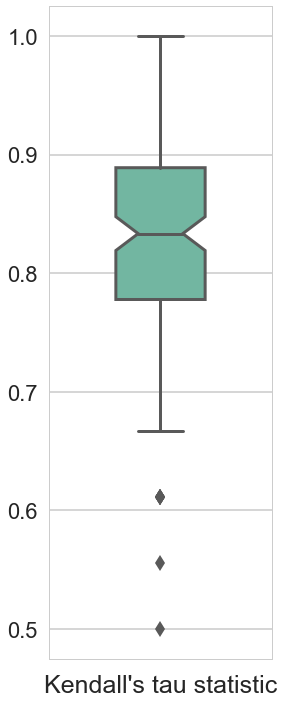

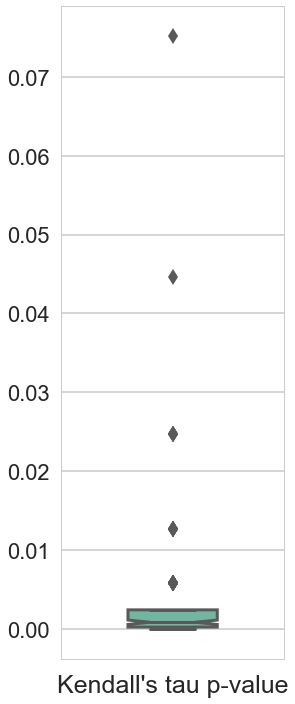

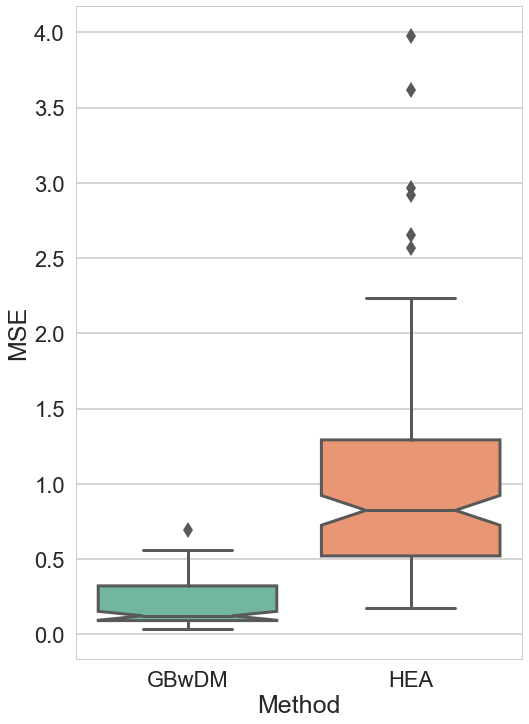

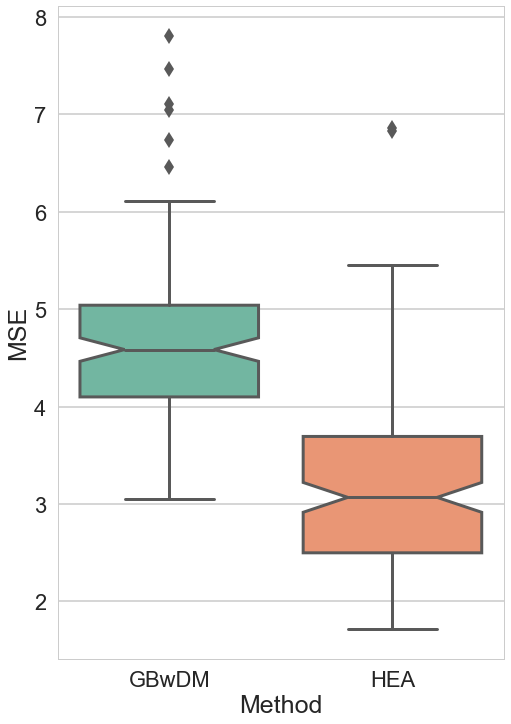

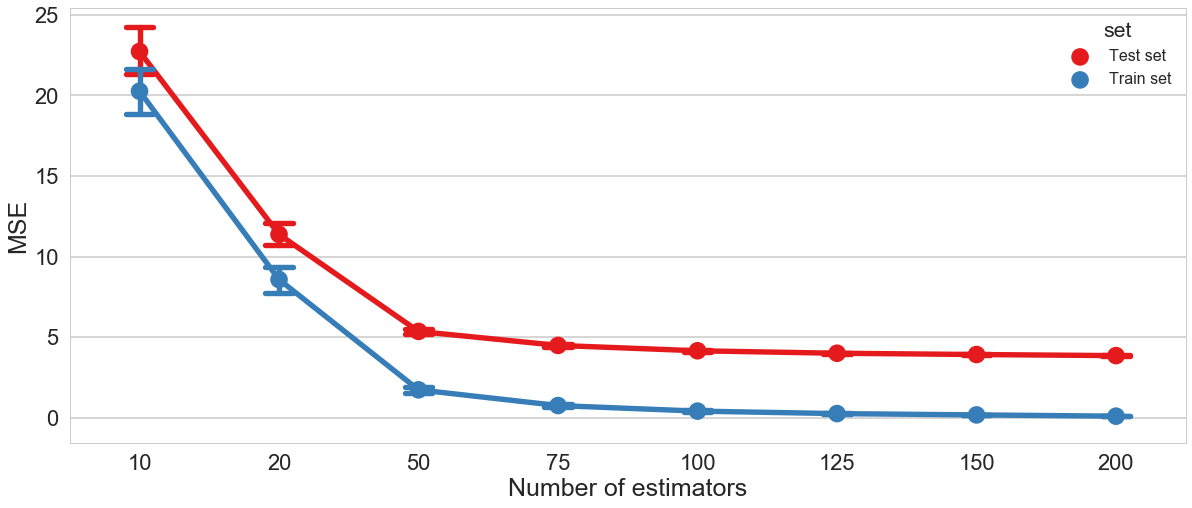

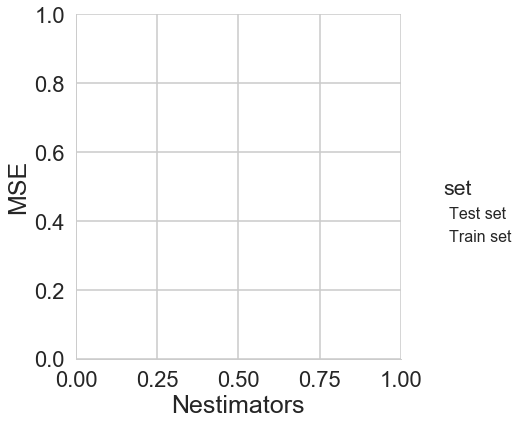

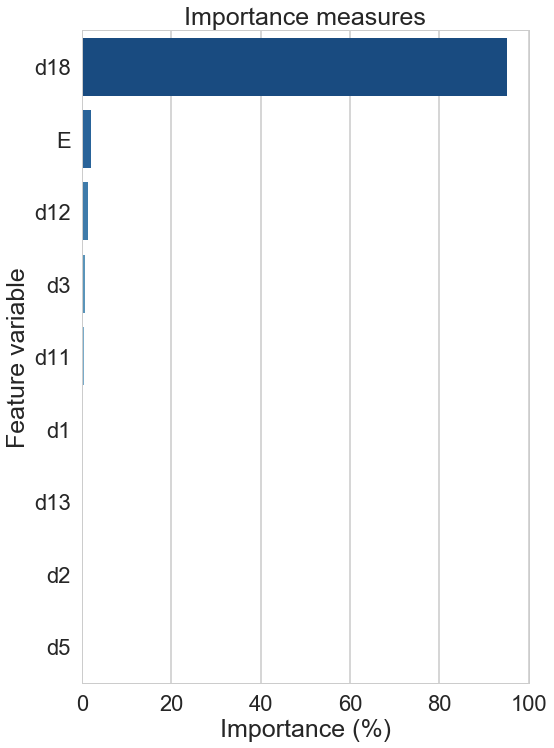

In [11]:

# Variable importance ranking Kendall's tau
data = pd.DataFrame(data=TAU, columns=['Kendall\'s tau statistic'])
f, ax = plt.subplots(figsize=(4, 12))
sns.boxplot(data, notch=True, width=0.4, palette = "Set2", orient='v', ax=ax, fliersize=12)
ax.set_xlabel('Kendall\'s tau statistic')
print("Kendall's tau statistic median: {}".format(np.median(TAU)))

# Variable importance ranking test p-value
data = pd.DataFrame(data=PVAL, columns=['Kendall\'s tau p-value'])
f, ax = plt.subplots(figsize=(4, 12))
sns.boxplot(data, notch=True, width=0.4, palette = "Set2", orient='v', ax=ax, fliersize=12)
ax.set_xlabel('Kendall\'s tau p-value')
print("Kendall's tau test p-value median: {}".format(np.median(PVAL)))
  
# Training MSE distribution
dataTr = pd.DataFrame(data=freqs[:,:,0].transpose(), columns=['GBwDM', 'HEA'])
dataTr['set'] = 'Training set'

# Testing MSE distribution
dataTe = pd.DataFrame(data=freqs[:,:,1].transpose(), columns=['GBwDM', 'HEA'])
dataTe['set'] = 'Testing set'

# Testing/Training MSE distribution (unified plot)
new_data1 = pd.DataFrame({'MSE':dataTr['GBwDM'], 'set':dataTr['set'], 'Method':'GBwDM'})
new_data1 = new_data1.append(pd.DataFrame({'MSE':dataTr['HEA'], 'set':dataTr['set'], 'Method':'HEA'}))
f, ax = plt.subplots(figsize=(8, 12))
sns.boxplot(x='Method', y='MSE', data=new_data1, palette = "Set2", notch=True, width=0.8, fliersize=12)
new_data2 = pd.DataFrame({'MSE':dataTe['GBwDM'], 'set':dataTe['set'], 'Method':'GBwDM'})
new_data2 = new_data2.append(pd.DataFrame({'MSE':dataTe['HEA'], 'set':dataTe['set'], 'Method':'HEA'}))
f, ax = plt.subplots(figsize=(8, 12))
sns.boxplot(x='Method', y='MSE', data=new_data2, palette = "Set2", notch=True, width=0.8, fliersize=12)

# Screen printing
print("WINS:\nGB:  %d\nST:  %d\n" % (gb_c, st_c))
print("FREQ max_features (0.5 = 'sqrt'):")
for k in mf_c:
  print("'{}' -> \t{}".format(k,mf_c[k]))
print("\nFREQ subsample:")
for k in ss_c:
  print("'{}' -> \t{}".format(k,ss_c[k]))
print("\nFREQ n_estimators:")
for k in ne_c:
  print("'{}' -> \t{}".format(k,ne_c[k]))
print("\nFREQ max_depth:")
for k in md_c:
  print("'{}' -> \t{}".format(k,md_c[k]))
print("\nMSE\tTrain\tTest\tIQR(test)\nGBwDM\t{:9.3f}\t{:9.3f}\t{:9.3f}\nHEA\t{:9.3f}\t{:9.3f}\t{:9.3f}".format(np.median(freqs[0,:,0]),np.median(freqs[0,:,1]), stats.iqr(freqs[0,:,1]),np.median(freqs[1,:,0]),np.median(freqs[1,:,1]), stats.iqr(freqs[1,:,1])))
print("\nMedian's test\tStat: {0[0]:9.3f}\tp-value: {0[1]:6.4f}".format(median_test(freqs[0,:,1],freqs[1,:,1])))

# MSE (test set) vs. Nestimators
f, ax = plt.subplots(figsize=(20, 8))
sns.factorplot(x='Nestimators', y="MSE", hue='set', data=MSErr, capsize=.2, palette = "Set1", size=6, ax=ax)
ax.set_ylabel('MSE')
ax.set_xlabel('Number of estimators')

# Plot feature importance
feature_importance = MODS['gb'].best_estimator_.feature_importances_   # From lastest seed
data = pd.DataFrame({'Variables':SMP['names'][:9], 'Importance':feature_importance*100})
data = data.sort_values(['Importance'], ascending=False).reset_index(drop=True)
sorted_idx = [x for _,x in zip(feature_importance, range(len(feature_importance)))] #np.argsort(feature_importance)
f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x='Importance', y='Variables', data=data, palette = "Blues_r", ax=ax)
ax.set_xlabel('Importance (%)')
ax.set_ylabel('Feature variable')
ax.set_title('Importance measures')

# Dumping weights of the heterogenous ensemble for posterior build
all_weights = pd.DataFrame()
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[0,:], 'Base':'SVR', 'Case':SMP['case']}))
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[1,:], 'Base':'LR', 'Case':SMP['case']}))
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[2,:], 'Base':'MLP', 'Case':SMP['case']}))
all_weights = all_weights.append(pd.DataFrame({'Coef': weights[3,:], 'Base':'GPR', 'Case':SMP['case']}))
filename = 'buck_weights.pickle'
with open(filename, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(all_weights, f, pickle.HIGHEST_PROTOCOL)    

In [12]:
feature_importance*100

array([2.14824244e-01, 7.71230238e-02, 5.64922190e-01, 6.36379320e-02,
       3.17693337e-01, 1.36800705e+00, 1.03237874e-01, 9.52144628e+01,
       2.07609158e+00])